In [1]:
from kan import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#checking if device is gpu or cpu
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(str(device) + ': ' + torch.cuda.get_device_name(0))
else:
    print(device)

cuda: NVIDIA GeForce GTX 1060 6GB


In [20]:
#formulas for the helix = [1/k cos(sk), 1/k sin(sk)]
def v0(s,k):
    x=torch.cos(s*k)/k
    y=torch.sin(s*k)/k
    return([x,y])

#first derivative
def dv0(s,k):
    x=-torch.sin(s*k)
    y=torch.cos(s*k)
    return([x,y])

#second derivative
def d2v0(s,k):
    x=-torch.cos(s*k)*k
    y=-torch.sin(s*k)*k
    return([x,y])

#dummy function to create tensor batch of constant curvature k1 on domain
k1=1.
def k(s):
    y=k1*torch.exp(s*0)
    return(y)

#initial conditions
s1 = torch.tensor([[0.]],requires_grad=True,device=device)
vB = torch.tensor([v0(s1,k(s1))],requires_grad=True,device=device)
tB = torch.tensor([dv0(s1,k(s1))],requires_grad=True,device=device)
nB = torch.tensor([d2v0(s1,k(s1))],requires_grad=True,device=device)

print(f' vB={vB}\n tB={tB}\n nB={nB}')

 vB=tensor([[1., 0.]], device='cuda:0', requires_grad=True)
 tB=tensor([[-0., 1.]], device='cuda:0', requires_grad=True)
 nB=tensor([[-1., -0.]], device='cuda:0', requires_grad=True)


In [3]:
#create model
wx=1.25
wb=1.
wk=1.5
n_epochs = 1850
batch_size = 85
lrate = 0.01
domain = (-1.5,1.5)
sample_size=batch_size

modelsys = KAN(width=[1,10,5,2], grid=5, k=3, seed=42, device=device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [4]:
#training the model
import time
losstep = []
lossal = []
lossd2l = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    loss = (wx*lossa + wb*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        timei=time.time()
        dti=round((timei-start)/60,1)
        prci=round((epoch/n_epochs)*100)
        tf=round(dti*(n_epochs/epoch -1),1)
        #print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, dt_loss: {lossd2v}, bd_loss: {lossbd}')
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        print(f'ETA: {tf} min')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')


/home/sam/Documents/pykan-master/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/sam/Documents/pykan-master/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/sam/Documents/pykan-master/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  output_range_spline = torch.std(postacts_numerical, dim=0) # for training, o

Finished epoch 184 (10%), latest loss 0.005346515183608764, k_loss: 0.003402347971504365, bd_loss: 1.4253598498423293e-05
ETA: 10.9 min
Finished epoch 369 (20%), latest loss 0.00039583008190149834, k_loss: 0.0001765101087589486, bd_loss: 1.0758516117113404e-05
ETA: 9.2 min
Finished epoch 554 (30%), latest loss 0.00025983210537572886, k_loss: 0.00010650706536177642, bd_loss: 1.620572279738369e-05
ETA: 8.2 min
Finished epoch 739 (40%), latest loss 0.000313731973394889, k_loss: 0.00015113551397492953, bd_loss: 1.453417375364511e-05
ETA: 7.1 min
Finished epoch 924 (50%), latest loss 0.0010716328900808767, k_loss: 0.00041459077756234323, bd_loss: 0.0003058651242250029
ETA: 5.8 min
Finished epoch 1109 (60%), latest loss 0.0006849567611215479, k_loss: 0.00029495570359465624, bd_loss: 0.00015633036130203773
ETA: 4.7 min
Finished epoch 1294 (70%), latest loss 0.0012546914983825623, k_loss: 0.000625342283399884, bd_loss: 7.780300622323025e-05
ETA: 3.5 min
Finished epoch 1479 (80%), latest loss 0

Curvature accuracy: -0.0016822648467496037


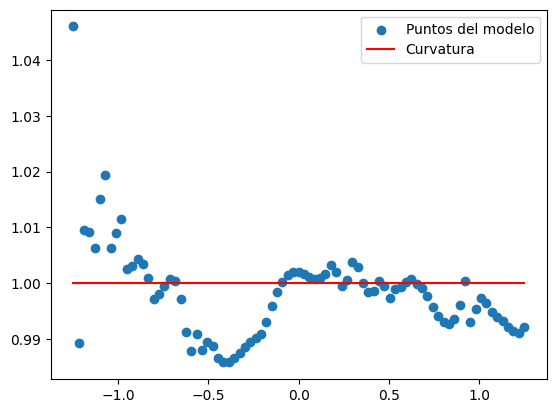

In [5]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
plt.savefig('c1_curvature.png')
plt.show()

Accuracy: x1 -0.002138720825314522, x2: -0.0027409526519477367


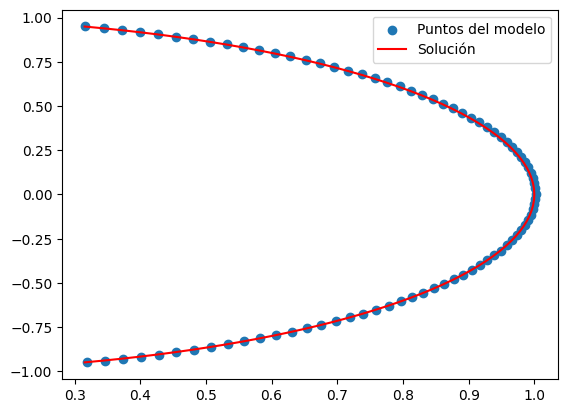

In [6]:
#verify true solution 
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
a0=v0(ti,k(ti))
accx = (a0[0] - xi).float().mean()
accy = (a0[1] - yi).float().mean()
a0[0]=a0[0].detach().cpu().numpy()
a0[1]=a0[1].detach().cpu().numpy()
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Accuracy: x1 {accx}, x2: {accy}')
plt.scatter(xi,yi,label='Puntos del modelo')
plt.plot(a0[0],a0[1],label='Solución',color='r')
plt.legend()
plt.savefig('c1_solution.png')
plt.show()

Last loss: 0.0008265789564290435


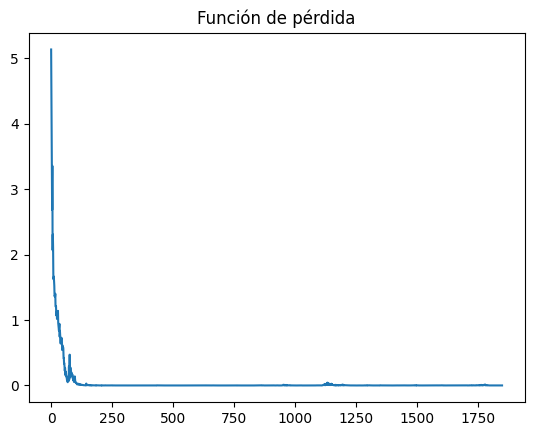

In [7]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1_loss1.png')
plt.show()

Last loss: 0.0004005316924036493


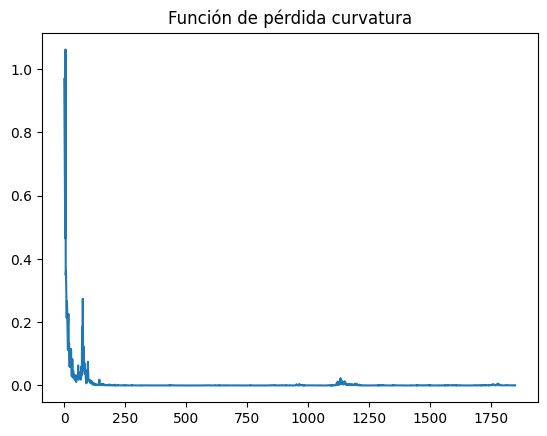

In [8]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1_loss2.png')
plt.show()

Last loss: 0.00016746302866155636


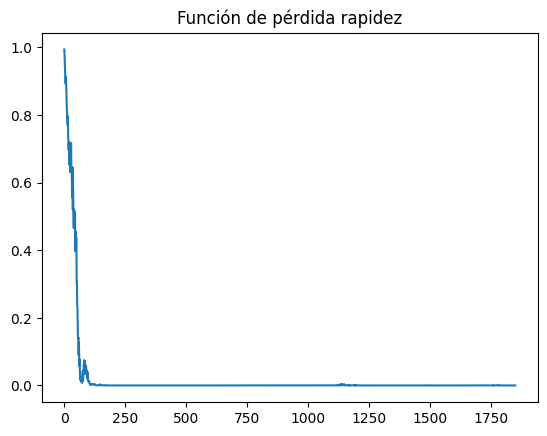

In [9]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1_loss3.png')
plt.show()

In [21]:
#create model
wx=1.25
wy=1
wb=1.
wk=1.5
n_epochs = 3850
batch_size = 85
lrate = 0.001
domain = (-2.5,2.5)
sample_size=batch_size

modelsys1 = KAN(width=[1,10,5,2], grid=5, k=3, seed=42, device=device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys1.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [22]:
#training the model
import time
losstep = []
lossal = []
lossd2l = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys1(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys1(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    loss = (wx*lossa + wb*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        timei=time.time()
        dti=round((timei-start)/60,1)
        prci=round((epoch/n_epochs)*100)
        tf=round(dti*(n_epochs/epoch -1),1)
        #print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, dt_loss: {lossd2v}, bd_loss: {lossbd}')
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        print(f'ETA: {tf} min')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 384 (10%), latest loss 0.9553868803380043, k_loss: 0.1787934229530703, bd_loss: 0.0034476901044574303
ETA: 22.6 min
Finished epoch 769 (20%), latest loss 0.6070215522426885, k_loss: 0.07620437975762001, bd_loss: 0.0017760564161011687
ETA: 20.0 min
Finished epoch 1154 (30%), latest loss 0.48301603150007144, k_loss: 0.08201107710037997, bd_loss: 0.0002445428809774965
ETA: 17.5 min
Finished epoch 1539 (40%), latest loss 0.3745302469079584, k_loss: 0.062472181135365075, bd_loss: 0.00048168882339047654
ETA: 15.0 min
Finished epoch 1924 (50%), latest loss 0.4670679865716751, k_loss: 0.07556744010563288, bd_loss: 0.0009108470266328019
ETA: 12.5 min
Finished epoch 2309 (60%), latest loss 0.14456739514765246, k_loss: 0.021037753481335904, bd_loss: 0.0009129271752726242
ETA: 10.0 min
Finished epoch 2694 (70%), latest loss 0.06172776589410825, k_loss: 0.01968338598065814, bd_loss: 0.001187706084401084
ETA: 7.5 min
Finished epoch 3079 (80%), latest loss 0.022748676569753722, k_loss:

Curvature accuracy: 0.00032850707066245377


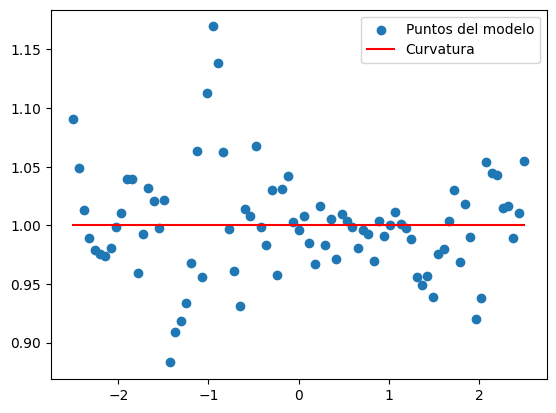

In [23]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys1(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
plt.savefig('c1a_curvature.png')
plt.show()

Accuracy: x1 -0.36174917221069336, x2: 0.21041885018348694


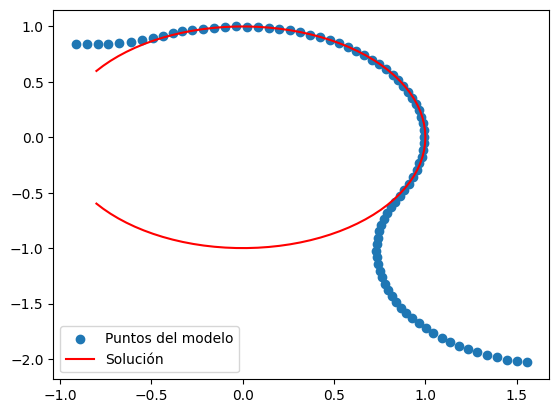

In [24]:
#verify true solution 
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
a0=v0(ti,k(ti))
accx = (a0[0] - xi).float().mean()
accy = (a0[1] - yi).float().mean()
a0[0]=a0[0].detach().cpu().numpy()
a0[1]=a0[1].detach().cpu().numpy()
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Accuracy: x1 {accx}, x2: {accy}')
plt.scatter(xi,yi,label='Puntos del modelo')
plt.plot(a0[0],a0[1],label='Solución',color='r')
plt.legend()
plt.savefig('c1a_solution.png')
plt.show()

Last loss: 0.008704078861597912


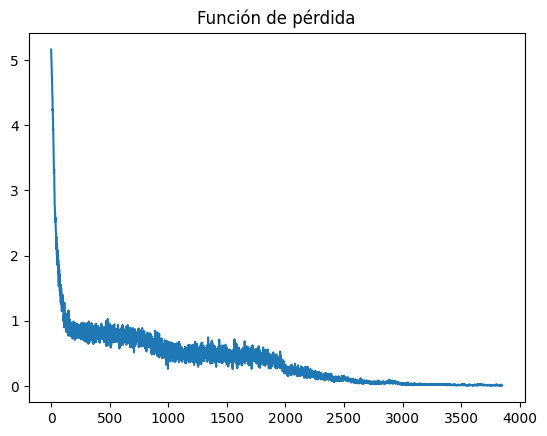

In [25]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1a_loss1.png')
plt.show()

Last loss: 0.003428231104148439


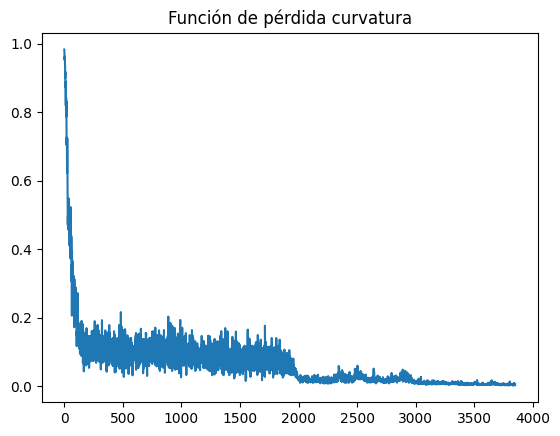

In [26]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1a_loss2.png')
plt.show()

Last loss: 0.0026629148409324315


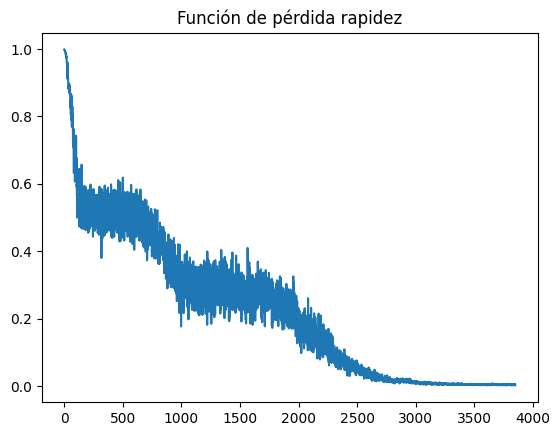

In [27]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('c1a_loss3.png')
plt.show()

In [2]:
#formulas for the helix = [1/k cos(sk), 1/k sin(sk)]
def v0(s,k):
    x=torch.cos(s*k)/k
    y=torch.sin(s*k)/k
    return([x,y])

#first derivative
def dv0(s,k):
    x=-torch.sin(s*k)
    y=torch.cos(s*k)
    return([x,y])

#second derivative
def d2v0(s,k):
    x=-torch.cos(s*k)*k
    y=-torch.sin(s*k)*k
    return([x,y])

#curvature of a parabola y=x**2
def k(s):
    y=2/torch.sqrt((1+4*s**2)**3)
    return(y)

#initial conditions
s1 = torch.tensor([[0.]],requires_grad=True,device=device)
vB = torch.tensor([v0(s1,k(s1))],requires_grad=True,device=device)
tB = torch.tensor([dv0(s1,k(s1))],requires_grad=True,device=device)
nB = torch.tensor([d2v0(s1,k(s1))],requires_grad=True,device=device)

print(f' vB={vB}\n tB={tB}\n nB={nB}')

 vB=tensor([[0.5000, 0.0000]], device='cuda:0', requires_grad=True)
 tB=tensor([[-0., 1.]], device='cuda:0', requires_grad=True)
 nB=tensor([[-2., -0.]], device='cuda:0', requires_grad=True)


In [7]:
#create model
wx=1.25
wb=1.
wk=1.5
n_epochs = 1850
batch_size = 85
lrate = 0.01
domain = (-1.25,1.25)
sample_size=batch_size

modelsys = KAN(width=[1,10,5,2], grid=5, k=3, seed=42, device=device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [8]:
import time
losstep = []
lossal = []
lossd2l = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    #d2v_residual = d2v1 - k(s)*d2v1/norm + d2v2 - k(s)*d2v2/norm
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    #d2vp = torch.autograd.grad(dvp.sum(), s1, create_graph=True)[0]
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    #lossd2v = loss_fn(d2v_residual,torch.zeros_like(d2v_residual))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    #loss = (wx*lossa + wk*lossd2v + wb*(lossbv + lossbdv + lossbd2v))
    loss = (wx*lossa + wb*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    #lossd2l.append(lossd2v.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        timei=time.time()
        dti=round((timei-start)/60,1)
        prci=round((epoch/n_epochs)*100)
        tf=round(dti*(n_epochs/epoch -1),1)
        #print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, dt_loss: {lossd2v}, bd_loss: {lossbd}')
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        print(f'ETA: {tf} min')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 184 (10%), latest loss 0.008184039115765512, k_loss: 0.00443145895872566, bd_loss: 0.0011310120386223118
ETA: 10.9 min
Finished epoch 369 (20%), latest loss 0.0007508726661522281, k_loss: 0.00041424979026006436, bd_loss: 1.0500195499946513e-06
ETA: 9.2 min
Finished epoch 554 (30%), latest loss 0.0002712053860240276, k_loss: 0.00013251656952240656, bd_loss: 6.892050538726176e-06
ETA: 8.2 min
Finished epoch 739 (40%), latest loss 0.01843066705882876, k_loss: 0.005153377061015737, bd_loss: 0.010358908162348284
ETA: 6.9 min
Finished epoch 924 (50%), latest loss 0.0005861118922334596, k_loss: 0.0002744819686291045, bd_loss: 0.00010520195327894031
ETA: 5.8 min
Finished epoch 1109 (60%), latest loss 0.0013328368292554863, k_loss: 0.00044415572477636995, bd_loss: 0.0005922309164564632
ETA: 4.7 min
Finished epoch 1294 (70%), latest loss 0.00015383581445733703, k_loss: 8.184584648563269e-05, bd_loss: 2.9069048567399497e-06
ETA: 3.5 min
Finished epoch 1479 (80%), latest loss 0.0032

Curvature accuracy: 0.0005145816248841584


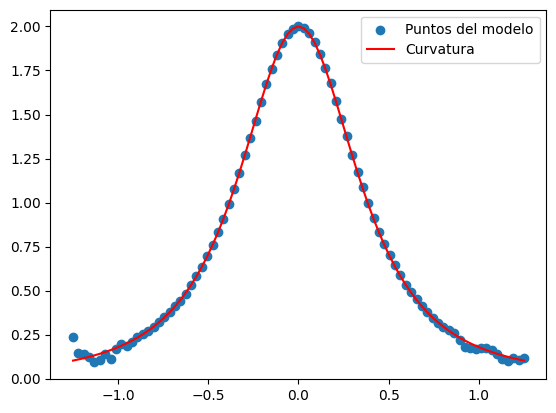

In [10]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
plt.savefig('p1_curvature.png')
plt.show()

Accuracy: -0.0331958569586277


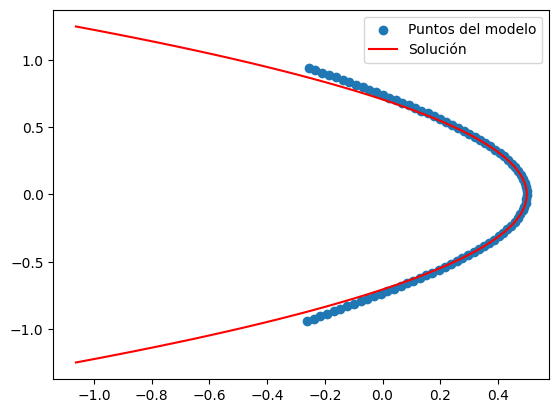

In [11]:
#verify true solution 
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
a0=-ti*ti+.5
accy = (a0 - yi).float().mean()
a0=a0.detach().cpu().numpy()
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Accuracy: {accy}')
plt.scatter(xi,yi,label='Puntos del modelo')
plt.plot(a0,ti,label='Solución',color='r')
plt.legend()
plt.savefig('p1_solution.png')
plt.show()

Last loss: 0.00015819450452143535


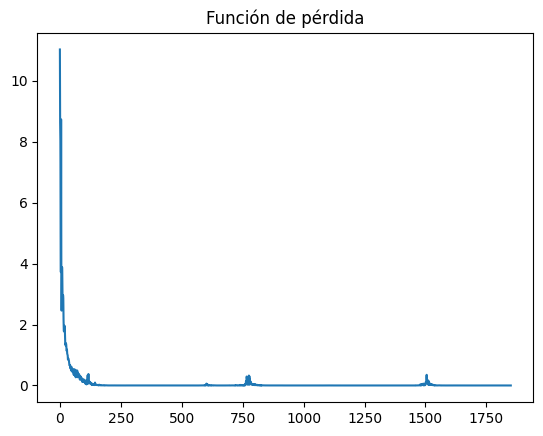

In [12]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('p1_loss1.png')
plt.show()

Last loss: 6.91390647704761e-05


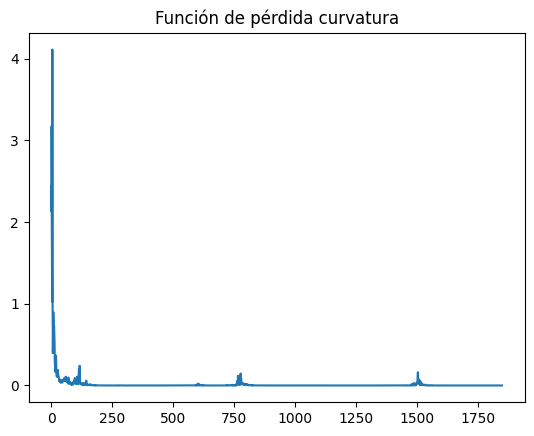

In [13]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('p1_loss2.png')
plt.show()

Last loss: 2.9138248834324305e-05


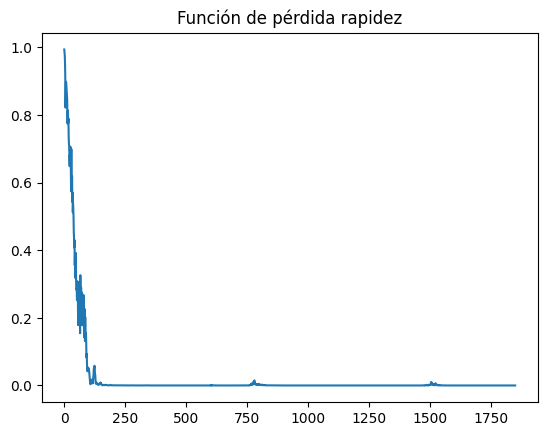

In [14]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('p1_loss3.png')
plt.show()

In [6]:
#formulas for the helix = [1/k cos(sk), 1/k sin(sk)]
def v0(s,k):
    x=torch.cos(s*k)/k
    y=torch.sin(s*k)/k
    return([x,y])

#first derivative
def dv0(s,k):
    x=-torch.sin(s*k)
    y=torch.cos(s*k)
    return([x,y])

#second derivative
def d2v0(s,k):
    x=-torch.cos(s*k)*k
    y=-torch.sin(s*k)*k
    return([x,y])

#curvature for the euler curve
def k(s):
    y=s
    return(y)

#initial conditions
s1 = torch.tensor([[1.5]],requires_grad=True,device=device)
vB = torch.tensor([v0(s1,k(s1))],requires_grad=True,device=device)
tB = torch.tensor([dv0(s1,k(s1))],requires_grad=True,device=device)
nB = torch.tensor([d2v0(s1,k(s1))],requires_grad=True,device=device)

print(f' vB={vB}\n tB={tB}\n nB={nB}')

 vB=tensor([[-0.4188,  0.5187]], device='cuda:0', requires_grad=True)
 tB=tensor([[-0.7781, -0.6282]], device='cuda:0', requires_grad=True)
 nB=tensor([[ 0.9423, -1.1671]], device='cuda:0', requires_grad=True)


In [7]:
#setting up the model
wx=1.25
wy=1
wb=1.
wk=1.5
n_epochs = 6550
batch_size = 85
lrate = 0.01
domain = (.75,4.75)
sample_size=batch_size

modelsys = KAN(width=[1,10,5,2], grid=5, k=3, seed=42, device=device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [8]:
#training the model
import time
losstep = []
lossal = []
lossd2l = []
losskl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    s = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(s)
    v1 = v[:,0].reshape(batch_size,1)
    v2 = v[:,1].reshape(batch_size,1)
    dv1 = torch.autograd.grad(v1.sum(), s, create_graph=True)[0]
    d2v1 = torch.autograd.grad(dv1.sum(), s, create_graph=True)[0]
    dv2 = torch.autograd.grad(v2.sum(), s, create_graph=True)[0]
    d2v2 = torch.autograd.grad(dv2.sum(), s, create_graph=True)[0]
    norm = torch.sqrt(d2v1**2 + d2v2**2)
    
    dv_arc1 = dv1**2 + dv2**2 - 1
    k_residual = d2v1**2 + d2v2**2 - k(s)**2
    
    v_pred1 = modelsys(s1)
    bv = v_pred1 - vB
    dvxp = torch.autograd.grad(v_pred1[0][0].sum(), s1, create_graph=True)[0]
    dvyp = torch.autograd.grad(v_pred1[0][1].sum(), s1, create_graph=True)[0]
    d2vxp = torch.autograd.grad(dvxp.sum(), s1, create_graph=True)[0]
    d2vyp = torch.autograd.grad(dvyp.sum(), s1, create_graph=True)[0]
    
    bdv = dvxp + dvyp - tB[0][0] - tB[0][1]
    bd2v = d2vxp + d2vyp - nB[0][0] + nB[0][1]
    
    lossa = loss_fn(dv_arc1,torch.zeros_like(dv_arc1))
    lossk = loss_fn(k_residual,torch.zeros_like(k_residual))
    lossbv = loss_fn(bv,torch.zeros_like(bv))
    lossbdv = loss_fn(bdv,torch.zeros_like(bdv))
    lossbd2v = loss_fn(bd2v,torch.zeros_like(bd2v))
    lossbd = lossbv + lossbdv + lossbd2v
    
    loss = (wx*lossa + wb*(lossbv + lossbdv + lossbd2v) + wk*lossk)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossal.append(lossa.detach().cpu().numpy())
    losskl.append(lossk.detach().cpu().numpy())
    #lossd2l.append(lossd2v.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .05:
        timei=time.time()
        dti=round((timei-start)/60,1)
        prci=round((epoch/n_epochs)*100)
        tf=round(dti*(n_epochs/epoch -1),1)
        print(f'Finished epoch {epoch} ({prci}%), latest loss {loss}, k_loss: {lossk}, bd_loss: {lossbd}')
        print(f'ETA: {tf} min')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

/home/sam/Documents/pykan-master/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/sam/Documents/pykan-master/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/sam/Documents/pykan-master/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  output_range_spline = torch.std(postacts_numerical, dim=0) # for training, o

Finished epoch 327 (5%), latest loss 0.7204600124335392, k_loss: 0.3553256182974909, bd_loss: 0.016348147853767276
ETA: 38.1 min
Finished epoch 655 (10%), latest loss 0.23938941057245283, k_loss: 0.1323087808290405, bd_loss: 0.0028025991658777658
ETA: 36.9 min
Finished epoch 983 (15%), latest loss 0.824294749020802, k_loss: 0.529212704435056, bd_loss: 0.0017581723627725578
ETA: 34.5 min
Finished epoch 1311 (20%), latest loss 0.07587256134382328, k_loss: 0.03258344813842724, bd_loss: 0.00018416529208370704
ETA: 32.8 min
Finished epoch 1639 (25%), latest loss 0.07852455434503032, k_loss: 0.03045083224180543, bd_loss: 0.0019691789907213455
ETA: 30.9 min
Finished epoch 1967 (30%), latest loss 0.055296426534202546, k_loss: 0.02003631705585817, bd_loss: 0.0018197344825607064
ETA: 28.7 min
Finished epoch 2295 (35%), latest loss 0.3120098943092165, k_loss: 0.18307576184610128, bd_loss: 0.005781245960986066
ETA: 26.7 min
Finished epoch 2623 (40%), latest loss 0.08006196258980877, k_loss: 0.0317

Curvature accuracy: -0.009386323392391205


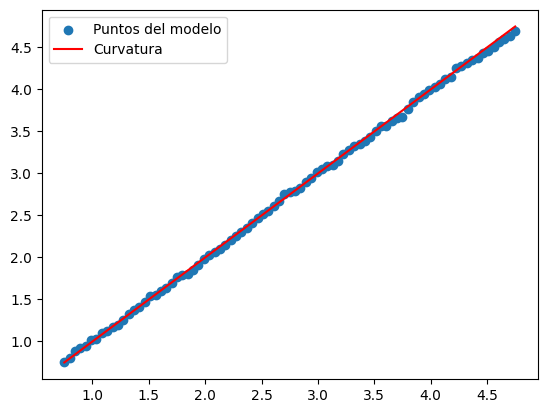

In [10]:
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
vi=modelsys(ti) #predicted curve

#getting derivatives to evaluate predicted curvature
vi1 = vi[:,0].reshape(batch_size,1)
vi2 = vi[:,1].reshape(batch_size,1)
dvi1 = torch.autograd.grad(vi1.sum(), ti, create_graph=True)[0]
d2v1 = torch.autograd.grad(dvi1.sum(), ti, create_graph=True)[0]
dvi2 = torch.autograd.grad(vi2.sum(), ti, create_graph=True)[0]
d2v2 = torch.autograd.grad(dvi2.sum(), ti, create_graph=True)[0]
kpred= torch.sqrt(d2v1**2 + d2v2**2)
ki=k(ti)
acck = (kpred - ki).float().mean() #mean accuracy of curvature
kpred=kpred.reshape(sample_size,1).detach().cpu().numpy()
ki=ki.reshape(sample_size,1).detach().cpu().numpy() #true curvature
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
print(f'Curvature accuracy: {acck}')

plt.scatter(ti,kpred,label='Puntos del modelo')
plt.plot(ti,ki,color='r',label='Curvatura')
plt.legend()
#plt.savefig('e1_curvature.png')
plt.show()

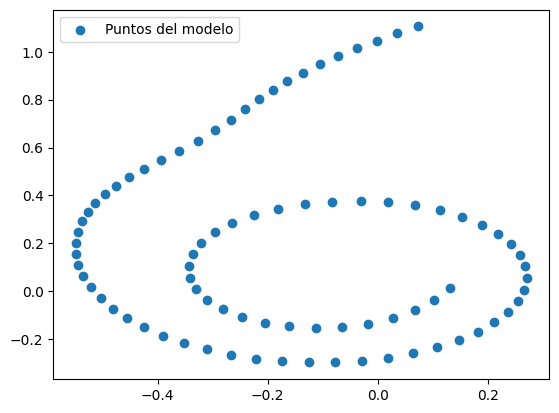

In [11]:
#plot of model points
ti=torch.linspace(domain[0],domain[1],sample_size,requires_grad=True,device=device).reshape(sample_size,1)
xi=vi[:,0]
yi=vi[:,1]
xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
plt.scatter(xi,yi,label='Puntos del modelo')
plt.legend()
#plt.savefig('e1_solution.png')
plt.show()

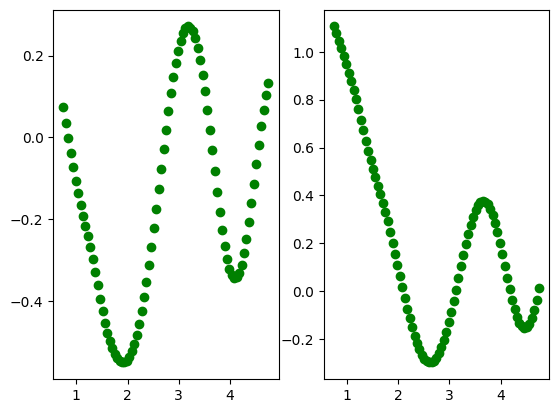

In [12]:
#plot of coordinates x(s),y(s)
figure, axis = plt.subplots(1, 2)
axis[0].scatter(ti,xi,color='g')
axis[1].scatter(ti,yi,color='g')
plt.savefig('e1_xysolution.png')
plt.show()

Last loss: 0.05456039909621673


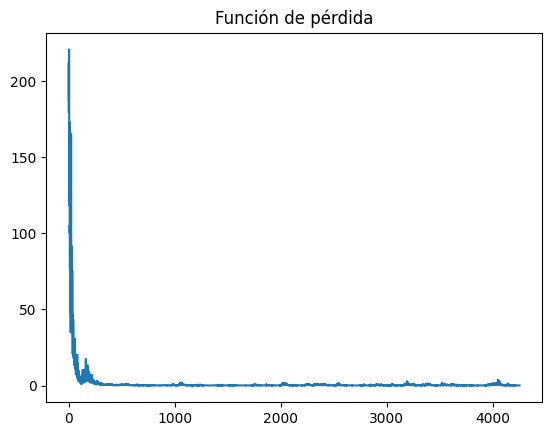

In [13]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Función de pérdida')
lastloss=losstep[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('e1_loss1.png')
plt.show()

Last loss: 0.02469294998513756


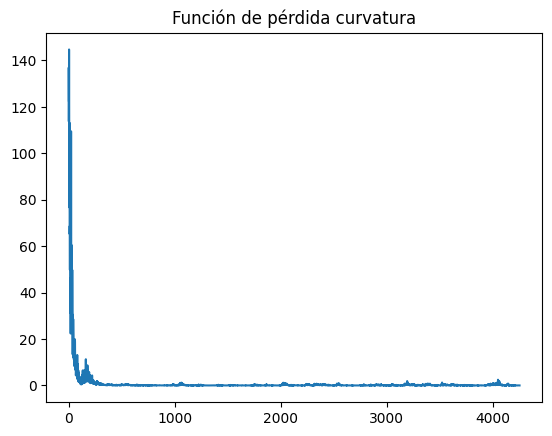

In [14]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losskl)
plt.title('Función de pérdida curvatura')
lastloss=losskl[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('e1_loss2.png')
plt.show()

Last loss: 0.012909272006934387


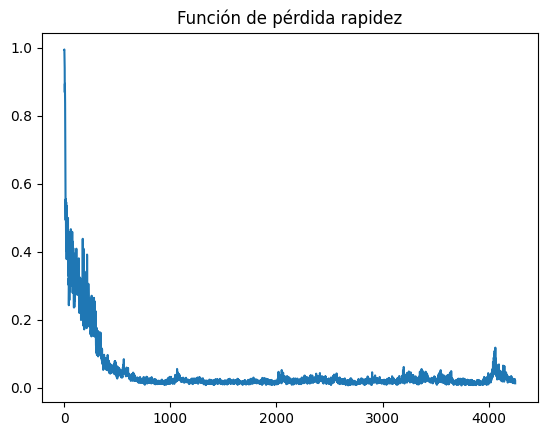

In [15]:
plt.plot(np.linspace(0,n_epochs,n_epochs),lossal)
plt.title('Función de pérdida rapidez')
lastloss=lossal[n_epochs-1]
print(f'Last loss: {lastloss}')
plt.savefig('e1_loss3.png')
plt.show()